In [99]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [100]:
# 1. backtest.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
import pprint
try:
    import Queue as queue
except ImportError:
    import queue
import time

print("Executing backtest.py")
class Backtest(object):
    """
    Enscapsulates the settings and components for carrying out
    an event-driven backtest.
    """
#     print("*****backtest.py: 01: Class Backtest(object)*****")
    def __init__(
        self, csv_dir, symbol_list, initial_capital,
        heartbeat, start_date, data_handler, 
        execution_handler, portfolio, strategy
    ):
        """
        Initialises the backtest.
        Parameters:
        csv_dir - The hard root to the CSV data directory.
        symbol_list - The list of symbol strings.
        intial_capital - The starting capital for the portfolio.
        heartbeat - Backtest "heartbeat" in seconds
        start_date - The start datetime of the strategy.
        data_handler - (Class) Handles the market data feed.
        execution_handler - (Class) Handles the orders/fills for trades.
        portfolio - (Class) Keeps track of portfolio current and prior positions.
        strategy - (Class) Generates signals based on market data.
        """
#         print("*****backtest.py: 1. Backtest.initializing..*****")
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.initial_capital = initial_capital
        self.heartbeat = heartbeat
        self.start_date = start_date

        self.data_handler_cls = data_handler
        self.execution_handler_cls = execution_handler
        self.portfolio_cls = portfolio
        self.strategy_cls = strategy

        # Added by Brad on 20191006
        # self.plots_cls = plots

        self.events = queue.Queue()
        
        self.signals = 0
        self.orders = 0
        self.fills = 0
        self.num_strats = 1
       
        self._generate_trading_instances()

    def _generate_trading_instances(self):
        # function1: call0 classes of 1)DataHandler, 2)strategy, 3)portfolion, 4)ExecutionHandler
        """
        Generates the trading instance objects from 
        their class types.
        """
#         print("*****backtest.py: 2. Backtest._generate_trading_instances*****")
#         print(
#             "backtest.py: _generate_trading_instances: Creating DataHandler, Strategy, Portfolio and ExecutionHandler"
#         )
        self.data_handler = self.data_handler_cls(self.events, self.csv_dir, self.symbol_list)
        self.strategy = self.strategy_cls(self.data_handler, self.events)
        self.portfolio = self.portfolio_cls(self.data_handler, self.events, self.start_date, 
                                            self.initial_capital)
        self.execution_handler = self.execution_handler_cls(self.events)
    

    def _run_backtest(self): # 
        # function1: update market bars
        # function2: identify the current event, including 1)market, 2)signal, 3)order, 4)
        """
        Executes the backtest.
        """
#         print("*****backtest.py: 3. Backtest._run_backtest*****")
#         print("Running Backtest...")
        i = 0
        while True:
            i += 1
            # print(i)

            # Update the market bars
            if self.data_handler.continue_backtest == True:
                self.data_handler.update_bars()
            else:
                break

            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.strategy.calculate_signals(event)
                            self.portfolio.update_timeindex(event)

                        elif event.type == 'SIGNAL':
                            self.signals += 1                            
                            self.portfolio.update_signal(event)

                        elif event.type == 'ORDER':
                            self.orders += 1
                            self.execution_handler.execute_order(event)

                        elif event.type == 'FILL':
                            self.fills += 1
                            self.portfolio.update_fill(event)

            time.sleep(self.heartbeat)

	# OG version
    # def _output_performance(self):
    #     """
    #     Outputs the strategy performance from the backtest.
    #     """
    #     self.portfolio.create_equity_curve_dataframe()
        
    #     print("Creating summary stats...")
    #     stats = self.portfolio.output_summary_stats()
        
    #     print("Creating equity curve...")
    #     print(self.portfolio.equity_curve.tail(10))
    #     pprint.pprint(stats)

    #     print("Signals: %s" % self.signals)
    #     print("Orders: %s" % self.orders)
    #     print("Fills: %s" % self.fills)


    def _output_performance(self):
        """
        Outputs the strategy performance from the backtest.
        """
        self.portfolio.create_equity_curve_dataframe()
#         print("*****backtest.py: 4. Backtest._output_performance*****")
        print("Creating summary stats...")
        stats = self.portfolio.output_summary_stats()
        
        print("Creating equity curve...")
        print(self.portfolio.equity_curve.tail(10))
        pprint.pprint(stats)

        print("Signals: %s" % self.signals)
        print("Orders: %s" % self.orders)
        print("Fills: %s" % self.fills)

    def simulate_trading(self):
        # function 1: call 1)_run _backtest, 2__output_formance
        """
        Simulates the backtest and outputs portfolio performance.
        """
#         print("*****backtest.py: 5. Backtest.simulate_trading*****")
        self._run_backtest()
        self._output_performance()

Executing backtest.py


In [101]:
# 2. event.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

print("Executing event.py")
class Event(object):
    """
    Event is base class providing an interface for all subsequent 
    (inherited) events, that will trigger further events in the 
    trading infrastructure.   
    """
#     print("*****event.py: 01 Class. Event(object)*****")
    pass


class MarketEvent(Event):
    """
    Handles the event of receiving a new market update with 
    corresponding bars.
    """
#     print("*****event.py: 02 Class. MarketEvent(Event)*****")
    def __init__(self):
        """
        Initialises the MarketEvent.
        """
#         print("*****event.py: 1. initializing..*****")
        self.type = 'MARKET'


class SignalEvent(Event):
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    print("*****event.py: 03 Class: SignalEvent(Event)*****")
    def __init__(self, strategy_id, symbol, datetime, signal_type, strength):
        """
        Initialises the SignalEvent.
        Parameters:
        strategy_id - The unique ID of the strategy sending the signal.
        symbol - The ticker symbol, e.g. 'GOOG'.
        datetime - The timestamp at which the signal was generated.
        signal_type - 'LONG' or 'SHORT'.
        strength - An adjustment factor "suggestion" used to scale 
            quantity at the portfolio level. Useful for pairs strategies.
        """
#         print("*****event.py: 1. SignalEvent.initializing..*****")
        self.strategy_id = strategy_id
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        self.strength = strength


class OrderEvent(Event):
    """
    Handles the event of sending an Order to an execution system.
    The order contains a symbol (e.g. GOOG), a type (market or limit),
    quantity and a direction.
    """
    print("*****event.py: 04 Class: OrderEvent(Event)*****")
    def __init__(self, symbol, order_type, quantity, direction):
        """
        Initialises the order type, setting whether it is
        a Market order ('MKT') or Limit order ('LMT'), has
        a quantity (integral) and its direction ('BUY' or
        'SELL').
        TODO: Must handle error checking here to obtain 
        rational orders (i.e. no negative quantities etc).
        Parameters:
        symbol - The instrument to trade.
        order_type - 'MKT' or 'LMT' for Market or Limit.
        quantity - Non-negative integer for quantity.
        direction - 'BUY' or 'SELL' for long or short.
        """
#         print("*****event.py: 1. OrderEvent.initializing..*****")
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction

    def print_order(self):
        """
        Outputs the values within the Order.
        """
#         print("*****event.py: 2. OrderEvent.print_order*****")
        print(
            "Order: Symbol=%s, Type=%s, Quantity=%s, Direction=%s" % 
            (self.symbol, self.order_type, self.quantity, self.direction)
        )


class FillEvent(Event):
    """
    Encapsulates the notion of a Filled Order, as returned
    from a brokerage. Stores the quantity of an instrument
    actually filled and at what price. In addition, stores
    the commission of the trade from the brokerage.
    
    TODO: Currently does not support filling positions at
    different prices. This will be simulated by averaging
    the cost.
    """
#     print("*****event.py: 05 Class: FillEvent(Event)*****")
    def __init__(self, timeindex, symbol, exchange, quantity, 
                 direction, fill_cost, commission=None):
        """
        Initialises the FillEvent object. Sets the symbol, exchange,
        quantity, direction, cost of fill and an optional 
        commission.
        If commission is not provided, the Fill object will
        calculate it based on the trade size and Interactive
        Brokers fees.
        Parameters:
        timeindex - The bar-resolution when the order was filled.
        symbol - The instrument which was filled.
        exchange - The exchange where the order was filled.
        quantity - The filled quantity.
        direction - The direction of fill ('BUY' or 'SELL')
        fill_cost - The holdings value in dollars.
        commission - An optional commission sent from IB.
        """
#         print("*****event.py: 1. FillEvent.initializing..*****")
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost

        # Calculate commission
        if commission is None:
            self.commission = self.calculate_ib_commission()
        else:
            self.commission = commission

    def calculate_ib_commission(self):
        """
        Calculates the fees of trading based on an Interactive
        Brokers fee structure for API, in USD.
        This does not include exchange or ECN fees.
        Based on "US API Directed Orders":
        https://www.interactivebrokers.com/en/index.php?f=commission&p=stocks2
        """
#         print("*****event.py: 2. FillEvent.calculate_ib_commission*****")
#         full_cost = 1.3
#         if self.quantity <= 500:
#             full_cost = max(1.3, 0.013 * self.quantity)
#         else: # Greater than 500
#             full_cost = max(1.3, 0.008 * self.quantity)
        full_cost = commissions
        return full_cost

Executing event.py
*****event.py: 03 Class: SignalEvent(Event)*****
*****event.py: 04 Class: OrderEvent(Event)*****


In [102]:
# 3. data.py
#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
import os, os.path

import numpy as np
import pandas as pd

# from event import MarketEvent

print("Executing data.py")
class DataHandler(object):
    """
    DataHandler is an abstract base class providing an interface for
    all subsequent (inherited) data handlers (both live and historic).
    The goal of a (derived) DataHandler object is to output a generated
    set of bars (OHLCVI) for each symbol requested. 
    This will replicate how a live strategy would function as current
    market data would be sent "down the pipe". Thus a historic and live
    system will be treated identically by the rest of the backtesting suite.
    """
#     print("*****data.py: 01 Class: Datahandler(object) ran, an abstract base class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def get_latest_bar(self, symbol):
#         print("*****data.py: 1. DataHandler.get_latest_bar*****")
        """
        Returns the last bar updated.
        """
        raise NotImplementedError("Should implement get_latest_bar()")

    @abstractmethod
    def get_latest_bars(self, symbol, N=1):
#         print("*****data.py: 2. DataHandler.get_latest_bars*****")
        """
        Returns the last N bars updated.
        """
        raise NotImplementedError("Should implement get_latest_bars()")

    @abstractmethod
    def get_latest_bar_datetime(self, symbol):
#         print("*****data.py: 3. DataHandler.get_latest_bar_datetime*****")
        """
        Returns a Python datetime object for the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_datetime()")

    @abstractmethod
    def get_latest_bar_value(self, symbol, val_type):
#         print("*****data.py: 4. DataHandler.get_latest_bar_value*****")
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        from the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_value()")

    @abstractmethod
    def get_latest_bars_values(self, symbol, val_type, N=1):
#         print("*****data.py: 5. DataHandler.get_latest_bars_values*****")
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
        raise NotImplementedError("Should implement get_latest_bars_values()")

    @abstractmethod
    def update_bars(self):
#         print("*****data.py: 6. DataHandler.update_bars*****")
        """
        Pushes the latest bars to the bars_queue for each symbol
        in a tuple OHLCVI format: (datetime, open, high, low, 
        close, volume, open interest).
        """
        raise NotImplementedError("Should implement update_bars()")


class HistoricCSVDataHandler(DataHandler):
    """
    HistoricCSVDataHandler is designed to read CSV files for
    each requested symbol from disk and provide an interface
    to obtain the "latest" bar in a manner identical to a live
    trading interface. 
    """
    print("*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****")
    def __init__(self, events, csv_dir, symbol_list):
        
#         print("*****data.py: 1. HistoricCSVDataHandler.initializing..")
        """
        Initialises the historic data handler by requesting
        the location of the CSV files and a list of symbols.
        It will be assumed that all files are of the form
        'symbol.csv', where symbol is a string in the list.
        Parameters:
        events - The Event Queue.
        csv_dir - Absolute directory path to the CSV files.
        symbol_list - A list of symbol strings.
        """
        self.events = events
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list

        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True       
        self.bar_index = 0

        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        """
        Opens the CSV files from the data directory, converting
        them into pandas DataFrames within a symbol dictionary.
        For this handler it will be assumed that the data is
        taken from Yahoo. Thus its format will be respected.
        """
#         print("*****data.py: 2. HistoricCSVDataHandler._open_convert_csv_files")
        comb_index = None
        
        for s in self.symbol_list:
            # Load the CSV file with no header information, indexed on date
            self.symbol_data[s] = pd.io.parsers.read_csv(
                os.path.join(self.csv_dir, '%s.csv' % s),
                header=0, index_col=0, parse_dates=True,
                names=data_cols
            )
            self.symbol_data[s].reset_index(inplace = True)
            self.symbol_data[s].set_index("trade_date", inplace=True)
            # ).sort_values('date')
            # print("symbol_data",self.symbol_data[s])#######################
            # Combine the index to pad forward values
            if comb_index is None:
                comb_index = self.symbol_data[s].index
            else:
                comb_index.union(self.symbol_data[s].index)

            # Set the latest symbol_data to None
            self.latest_symbol_data[s] = []

        # Reindex the dataframes
        for s in self.symbol_list:
            self.symbol_data[s] = self.symbol_data[s].\
                reindex(index=comb_index, method='pad').iterrows()
                


    def _get_new_bar(self, symbol):
        """
        Returns the latest bar from the data feed.
        """
#         print("*****data.py: 3. HistoricCSVDataHandler._get_new_bar")
        for b in self.symbol_data[symbol]:
            yield b

    def get_latest_bar(self, symbol):
        """
        Returns the last bar from the latest_symbol list.
        """
#         print("*****data.py: 4. HistoricCSVDataHandler.get_latest_bar")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1]

    def get_latest_bars(self, symbol, N=1):
        """
        Returns the last N bars from the latest_symbol list,
        or N-k if less available.
        """
#         print("*****data.py: 5. HistoricCSVDataHandler.get_latest_bars")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-N:]

    def get_latest_bar_datetime(self, symbol):
        """
        Returns a Python datetime object for the last bar.
        """
#         print("*****data.py: 6. HistoricCSVDataHandler.get_latest_bar_datetime")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1][0]

    def get_latest_bar_value(self, symbol, val_type):
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
#         print("*****data.py: 7. HistoricCSVDataHandler.get_latest_bar_value")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return getattr(bars_list[-1][1], val_type)

    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
#         print("*****data.py: 8. HistoricCSVDataHandler.get_latest_bars_values")
        try:
            bars_list = self.get_latest_bars(symbol, N)
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return np.array([getattr(b[1], val_type) for b in bars_list])

    def update_bars(self):
        """
        Pushes the latest bar to the latest_symbol_data structure
        for all symbols in the symbol list.
        """
#         print("*****data.py: 9. HistoricCSVDataHandler.update_bars")
        for s in self.symbol_list:
            try:
                bar = next(self._get_new_bar(s))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[s].append(bar)
        self.events.put(MarketEvent())

Executing data.py
*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****


In [103]:
# 4. execution.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

# from event import FillEvent, OrderEvent

print("Executing execution.py")
class ExecutionHandler(object):
    """
    The ExecutionHandler abstract class handles the interaction
    between a set of order objects generated by a Portfolio and
    the ultimate set of Fill objects that actually occur in the
    market. 
    The handlers can be used to subclass simulated brokerages
    or live brokerages, with identical interfaces. This allows
    strategies to be backtested in a very similar manner to the
    live trading engine.
    """
#     print ("*****execution.py: 01. Class: ExecutionHandler(object): abstract class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def execute_order(self, event):
#         print("*****execution.py: 1. ExecutionHandler.execute_order*****")
        """
        Takes an Order event and executes it, producing
        a Fill event that gets placed onto the Events queue.
        Parameters:
        event - Contains an Event object with order information.
        """
        raise NotImplementedError("Should implement execute_order()")


class SimulatedExecutionHandler(ExecutionHandler):
    
    """
    The simulated execution handler simply converts all order
    objects into their equivalent fill objects automatically
    without latency, slippage or fill-ratio issues.
    This allows a straightforward "first go" test of any strategy,
    before implementation with a more sophisticated execution
    handler.
    """
#     print ("*****execution.py: 02. Class: SimulatedExecutionHandler(ExecutionHandler)*****")
    def __init__(self, events):
        """
        Initialises the handler, setting the event queues
        up internally.
        Parameters:
        events - The Queue of Event objects.
        """
#         print("*****execution.py: 1. SimulatedExecutionHandler.initializing..*****")
        self.events = events

    def execute_order(self, event):
        """
        Simply converts Order objects into Fill objects naively,
        i.e. without any latency, slippage or fill ratio problems.
        Parameters:
        event - Contains an Event object with order information.
        """
#         print("*****execution.py: 2. SimulatedExecutionHandler.execute_order*****")
        if event.type == 'ORDER':
            fill_event = FillEvent(
                datetime.datetime.utcnow(), event.symbol,
                'ARCA', event.quantity, event.direction, None
            )
            self.events.put(fill_event)

Executing execution.py


In [104]:
# 5. strategy.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import SignalEvent

print("Executing strategy.py")
class Strategy(object):
#     print("*****strategy.py: 01. Class: Strategy(object): abstract class*****")
    """
    Strategy is an abstract base class providing an interface for
    all subsequent (inherited) strategy handling objects.
    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.
    This is designed to work both with historic and live data as
    the Strategy object is agnostic to where the data came from,
    since it obtains the bar tuples from a queue object.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def calculate_signals(self):
#         print("*****strategy.py: 1. Strategy(object).calculate_signals*****")
        """
        Provides the mechanisms to calculate the list of signals.
        """
        raise NotImplementedError("Should implement calculate_signals()")

Executing strategy.py


In [204]:
# 6. portfolio.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
from math import floor
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import FillEvent, OrderEvent
# from performance import create_sharpe_ratio, create_drawdowns


print("Executing portfolio.py")
class Portfolio(object):
    
#     print("*****portfolio.py: 01. Portfolio(object)*****")
    """
    The Portfolio class handles the positions and market
    value of all instruments at a resolution of a "bar",
    i.e. secondly, minutely, 5-min, 30-min, 60 min or EOD.
    The positions DataFrame stores a time-index of the 
    quantity of positions held. 
    The holdings DataFrame stores the cash and total market
    holdings value of each symbol for a particular 
    time-index, as well as the percentage change in 
    portfolio total across bars.
    """

    def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         print("*****portfolio.py: 1. Portfolio.initializing...*****")
        """
        Initialises the portfolio with bars and an event queue. 
        Also includes a starting datetime index and initial capital 
        (USD unless otherwise stated).
        Parameters:
        bars - The DataHandler object with current market data.
        events - The Event Queue object.
        start_date - The start date (bar) of the portfolio.
        initial_capital - The starting capital in USD.
        """
        self.bars = bars
        self.events = events
        self.symbol_list = self.bars.symbol_list
        self.start_date = start_date
        self.initial_capital = initial_capital
        
        self.all_positions = self.construct_all_positions()
        self.current_positions = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        self.all_holdings = self.construct_all_holdings()
        self.current_holdings = self.construct_current_holdings()
        
        # Brad's add on 20191117
#         fill.direction = "None"
#         self.fill_cost = self.update_holdings_from_fill(self, fill)
        
        # =============brad's added on 20191117:===============
        self.len_symbol_list = len(symbol_list)
        
        
        print("Number of assets in the portfolio： ",self.len_symbol_list)
        print("Position Value for each asset: ", self.initial_capital/self.len_symbol_list)

        
    def construct_all_positions(self):
#         print("*****portfolio.py: 2. Portfolio.construct_all_positions*****")
        """
        Constructs the positions list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        return [d]

    def construct_all_holdings(self):
#         print("*****portfolio.py: 3. Portfolio.construct_all_holdings*****")
        """
        Constructs the holdings list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return [d]

    def construct_current_holdings(self):
#         print("*****portfolio.py: 4. Portfolio.construct_current_holdings*****")
        """
        This constructs the dictionary which will hold the instantaneous
        value of the portfolio across all symbols.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return d

    def update_timeindex(self, event):
#         print("*****portfolio.py: 5. Portfolio.update_timeindex*****")
        """
        Adds a new record to the positions matrix for the current 
        market data bar. This reflects the PREVIOUS bar, i.e. all
        current market data at this stage is known (OHLCV).
        Makes use of a MarketEvent from the events queue.
        """
        ##print("symbol_list",self.symbol_list)
        latest_datetime = self.bars.get_latest_bar_datetime(self.symbol_list[0])
        #######################
        
        
#         print("latest_datetime:", latest_datetime)
        # Update positions
        # ================
        dp = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dp['datetime'] = latest_datetime

        for s in self.symbol_list:
            dp[s] = self.current_positions[s]

        # Append the current positions
        self.all_positions.append(dp)

        # Update holdings
        # ===============
        dh = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dh['datetime'] = latest_datetime
        dh['cash'] = self.current_holdings['cash']
        dh['commission'] = self.current_holdings['commission']
        dh['total'] = self.current_holdings['cash']

        for s in self.symbol_list:
            # Approximation to the real value
            market_value = self.current_positions[s] * \
                self.bars.get_latest_bar_value(s, price_col)
            dh[s] = market_value
            dh['total'] += market_value

        # Append the current holdings
        self.all_holdings.append(dh)

    # ======================
    # FILL/POSITION HANDLING
    # ======================

    def update_positions_from_fill(self, fill):
#         print("*****portfolio.py: 6. Portfolio.update_positions_from_fill*****")
        """
        Takes a Fill object and updates the position matrix to
        reflect the new position.
        Parameters:
        fill - The Fill object to update the positions with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update positions list with new quantities
        self.current_positions[fill.symbol] += fill_dir*fill.quantity

    def update_holdings_from_fill(self, fill):
#         print("*****portfolio.py: 7. Portfolio.update_holdings_from_fill*****")
        """
        Takes a Fill object and updates the holdings matrix to
        reflect the holdings value.
        Parameters:
        fill - The Fill object to update the holdings with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update holdings list with new quantities
        fill_cost = self.bars.get_latest_bar_value(
            fill.symbol, price_col
        )
        cost = fill_dir * fill_cost * fill.quantity
        self.current_holdings[fill.symbol] += cost
        self.current_holdings['commission'] += fill.commission
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['total'] -= (cost + fill.commission)
        # Brad's add on 20191117
        return fill_cost

    def update_fill(self, event):
#         print("*****portfolio.py: 8. Portfolio.update_fill*****")
        """
        Updates the portfolio current positions and holdings 
        from a FillEvent.
        """
        if event.type == 'FILL':
            self.update_positions_from_fill(event)
            self.update_holdings_from_fill(event)

    def generate_naive_order(self, signal):
#         print("*****portfolio.py: 9. Portfolio.generate_naive_order*****")
        """
        Simply files an Order object as a constant quantity
        sizing of the signal object, without risk management or
        position sizing considerations.
        Parameters:
        signal - The tuple containing Signal information.
        """
        order = None

        symbol = signal.symbol
        direction = signal.signal_type
        strength = signal.strength
        # ================ Brad's change on 20191117 =================
        mkt_quantity = qty
        symbol_value = self.bars.get_latest_bar_value(symbol, price_col)
#         mkt_quantity = int(self.initial_capital/self.len_symbol_list/symbol_value)
        print("Asset: ", symbol, "symbol_value: ",symbol_value,  "mkt_quantity: ", mkt_quantity)
        cur_quantity = self.current_positions[symbol]
        order_type = 'MKT'

        if direction == 'LONG' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'BUY')
        if direction == 'SHORT' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'SELL')   
    
        if direction == 'EXIT' and cur_quantity > 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'SELL')
        if direction == 'EXIT' and cur_quantity < 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'BUY')
        return order

    def update_signal(self, event):
#         print("*****portfolio.py: 10. Portfolio.update_signal*****")
        """
        Acts on a SignalEvent to generate new orders 
        based on the portfolio logic.
        """
        if event.type == 'SIGNAL':
            order_event = self.generate_naive_order(event)
            self.events.put(order_event)

    # ========================
    # POST-BACKTEST STATISTICS
    # ========================

    def create_equity_curve_dataframe(self):
#         print("*****portfolio.py: 11. Portfolio.create_equity_curve_dataframe*****")
        """
        Creates a pandas DataFrame from the all_holdings
        list of dictionaries.
        """
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0+curve['returns']).cumprod()
        self.equity_curve = curve

    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown

        stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]

        self.equity_curve.to_csv(ticker+"_performance"+".csv")
#         return self.equity_curve
#         print(stats)


class Visualization(Portfolio):
    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown
        self.equity_curve['drawdown'].plot()

#         stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
#                  ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
#                  ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
#                  ("Drawdown Duration", "%d" % dd_duration)]

#     def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         self.stats_to_plot = super().output_summary_stats()

#     def plot_cash(self):
#         self.stats_to_plot['cash'].plot()

#     # Added by Brad on 20191007:
#     def draw_summary_plots(self):
#         print("*****portfolio.py: 13. Portfolio.draw_summary_plots*****")
#         self.equity_curve['equity_curve'].plot(figsize = (18,6))

Executing portfolio.py


In [106]:
class A:
    def fun(self):
        print('A.fun')
        
    def not_fun(self):
        print("A.not_fun")
        
    def series(self):
        return [1, 2, 3, 4, 5]

class B(A):
    def series(self):
        srs =super().series()
#         print('B.fun')
        print(srs)
    
b = B()
b.series()

[1, 2, 3, 4, 5]


In [107]:
# 7. performance.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

import numpy as np
import pandas as pd

print("Executing performance.py")
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)


def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

Executing performance.py


In [108]:
# mac.py
print("Executing mac.py")
class MovingAverageCrossStrategy(Strategy):
    print("*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****")
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 12/26 periods respectively.
    """

    def __init__(self, bars, events, short_window=12, long_window=26):
        print("*****mac.py: 1. MovingAverageCrossStrategy.initializing..*****")
        """
        Initialises the buy and hold strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_bought*****")
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought

    def calculate_signals(self, event):
        print("*****mac.py: 3. MovingAverageCrossStrategy.calculate_signals*****")
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.    

        Parameters
        event - A MarketEvent object. 
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)

                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

Executing mac.py
*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****


In [109]:
class MovingAverageConvergenceDivergence(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                if bars is not None and bars != []:
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    macd = exp1 - exp2
                    exp3 = macd.ewm(span=9, adjust=False).mean()
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > exp3.iloc[-1] and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < exp3.iloc[-1] and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [110]:
class Visualization(object):
    def __init__(self, bt_csv_dir, start_date_str):
        self.equity_curve = pd.read_csv(bt_csv_dir+"equity.csv")
        self.equity_curve.drop_duplicates("datetime", inplace = True)
        self.equity_curve =self.equity_curve[self.equity_curve['datetime']>start_date_str]
        self.equity_curve.index = self.equity_curve['datetime']
        self.equity_curve = self.equity_curve[self.equity_curve['total'].map(lambda x: str(x)!="nan")]
        self.equity_curve.drop(['datetime'], axis = 1, inplace=True)
        self.plot_size = [18, 6]
        
    def plot_commissions(self):
        self.equity_curve['commission'].plot(figsize = self.plot_size)
        
    def plot_cash(self):
        self.equity_curve['cash'].plot(figsize = self.plot_size)
        
    def plot_total(self):
        self.equity_curve['total'].plot(figsize = self.plot_size)
        
    def plot_returns(self):
        self.equity_curve['returns'].plot(figsize = self.plot_size)
        
    def plot_equity_curve(self):
        self.equity_curve['equity_curve'].plot(figsize = self.plot_size)
        
    def plot_drawdown(self):
        self.equity_curve['drawdown'].plot(figsize = self.plot_size)
        
    def return_equity_df(self):
        return self.equity_curve
    

In [192]:
# # Hansen's version
# def performance(data):
#     data['daily_PL'] = data['total']-data['total'].shift(1)

#     trade = False
#     profits = []
#     total_profit_per_trade = 0

#     for i in range(len(data)): 
#         if data.iloc[i]['market_value'] == 0.0 and data.iloc[i]['returns'] == 0.0 and trade:
#             trade = False
        
#             profits.append(total_profit_per_trade)
#             total_profit_per_trade = 0

#         if trade:
#             total_profit_per_trade += data.iloc[i]['daily_PL']

#         if data.iloc[i]['market_value'] != 0.0 and not trade:
#             trade = True
#             total_profit_per_trade += data.iloc[i]['daily_PL']

#     win_trade = list(filter(lambda x: x >0, profits))
#     loss_trade = list(filter(lambda x: x <0, profits))
#     num_win_trade = len(win_trade)
#     num_total_trade = len(profits)
#     win_rate = num_win_trade/num_total_trade*100
#     mean_win_loss_ratio = np.mean(win_trade)/(-np.mean(loss_trade))
#     bt_score = (win_rate/100*mean_win_loss_ratio-(1-win_rate/100))
#     print('win %:', num_win_trade/num_total_trade*100)
#     print('PL Ratio:', np.mean(win_trade)/(-np.mean(loss_trade)))
#     print('bt_score:', bt_score)
#     return win_rate, mean_win_loss_ratio, bt_score, profits

In [206]:
# Brad' revised version:

def performance(data):
    commissions = 5 # in USD or RMB
    # Create daily PnL
    data['daily_PL'] = data['total']-data['total'].shift(1)
    trade = False
    profits = []
    total_profit_per_trade = 0
#     trade_count = 0
#     trade_stats = {}
    for i in range(len(data)): 
        
        
        # 1.1 open the position:
        if i > 1 and data.iloc[i-1]['market_value'] == 0 and data.iloc[i]['market_value'] != 0:
            print("-------------------")
            print("Opened the position: ", data.iloc[i]['datetime'])
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 1.2 open the position (if there's no data before):
        if i == 0 and data.iloc[i]['market_value'] != 0:
            print("No data before, opened the position: ", data.iloc[i]['datetime'])
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 2. holding the position:
        if i > 1 and data.iloc[i-1]['market_value'] != 0 and data.iloc[i]['market_value'] != 0:
            print("Holding the position: ", data.iloc[i]['datetime'])
            total_profit_per_trade += data.iloc[i]['daily_PL']
            
            
        # 3. close the position:
        if i > 1 and data.iloc[i-1]['market_value'] !=0 and data.iloc[i]['market_value'] == 0:
            print("Closed the position: ", data.iloc[i]['datetime'])
            profits.append(total_profit_per_trade)
            # The most recent trade is over, reset total_profit_per_trade
            print("This trade's pnl:", total_profit_per_trade)
            total_profit_per_trade = 0
            print("-------------------")
        
            
        # 4. if the position is empty 
        if data.iloc[i]['market_value'] == 0:
            print("Position is empty: ", data.iloc[i]['datetime'])
            

    win_trade = list(filter(lambda x: x >0, profits))
    loss_trade = list(filter(lambda x: x <0, profits))
    num_win_trade = len(win_trade)
    num_total_trade = len(profits)
    win_rate = num_win_trade/num_total_trade*100
    mean_win_loss_ratio = np.mean(win_trade)/(-np.mean(loss_trade))
    bt_score = (win_rate/100*mean_win_loss_ratio-(1-win_rate/100))
    total_commission = data['commission'].values[-1]
    gross_profit = sum(profits)+total_commission
    net_profit = sum(profits)
    commission_cost_rate = total_commission/gross_profit
    print('total_commission: ', total_commission)
    print('gross_profit: ', round(gross_profit,2))
    print('net_profit: ', round(net_profit,2))
    print('commission_impact: {}%'.format(round(commission_cost_rate*100, 2)))
    print('win %:', round(num_win_trade/num_total_trade*100,2))
    print('PL Ratio:', round(np.mean(win_trade)/(-np.mean(loss_trade)),2))
    return win_rate, mean_win_loss_ratio, bt_score, profits

In [234]:
symbol_list = [
#         "000069.SZ",#华侨城A
#         "002524.SZ",#光正集团
        "600712.SH",#南宁百货
    
]
ticker_performances = {}

if __name__ == "__main__":
    for ticker in symbol_list:
    # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
        equity_folder = "./"
        csv_dir = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    #     symbol_list = [

    # # ==============ETF================
    # #         "518880", # 黄金ETF
    # #         "513050",# 中概互联网
    # #         "513100",# 纳指ETF
    # #         "159920",# 恒生ETF
    # #         "510900",# 【H股ETF：弃，MACD不赚钱】
    # #         "512010",#医药ETF，
    # # ==============股票================
    # #         "002559.SZ",
    # #         "002638.SZ",
    # #         "601899.SH",#紫金矿业
    # #         "600208.SH",#新湖中宝、所属板块：参股券商
    # #         "000069.SZ",#华侨城A
    # #         "002524.SZ",#光正集团
    # #         "600712.SH",#南宁百货
    # #         "002610.SZ",#爱康科技
    # #         "601777.SH",#【力帆股份：基本面弱，暂弃】
    #         "002094.SZ",#青岛金王
    # #         "600467.SH"#【好当家：股价涨太高，暂时弃】

    #     ]
    #     data_cols = ['trade_date', 'open', 'high','low', 'close', 'volume','ts_code'] #for ETFs
        data_cols = ['ts_code','trade_date','open','high','low','close','pre_close','change','pct_chg','vol','amount'] #for stocks
        commissions = 5
    #     symbol_list = ['TSLA','AMZN','AAPL']
    #     symbol_list = ['SPY']
    #     symbol_list = ["VTI","TLT","IEF","GLD","DBC"]
    #     symbol_list = ['jd000d']
        initial_capital = 1000000.0
        start_date = datetime.datetime(1991,12,1,0,0,0)
        start_date_str = str(start_date)
        heartbeat = 0.0
        price_col = "close"
        qty = 2000
        backtest = Backtest(csv_dir, 
                            [ticker], 
                            initial_capital, 
                            heartbeat,
                            start_date,
                            HistoricCSVDataHandler, 
                            SimulatedExecutionHandler, 
                            Portfolio, 
    #                         MovingAverageCrossStrategy,
                           MovingAverageConvergenceDivergence)

        backtest.simulate_trading()
        df_equity = pd.read_csv(ticker+"_performance"+".csv")
        df_equity.drop_duplicates("datetime", inplace = True)
        df_equity =df_equity[df_equity['datetime']>start_date_str]
        df_equity.index = df_equity['datetime']
        df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
        df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
        'equity_curve', 'drawdown']
        df_equity_copy = df_equity.copy()
        data = df_equity_copy
        win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
#         print("TICKER: ", ticker)
        ticker_performances[ticker] = bt_score

Number of assets in the portfolio：  1
Position Value for each asset:  1000000.0
Asset:  600712.SH symbol_value:  3.6961 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  3.5377 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  3.9358 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  3.6799 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.2119 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.4475 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.6019 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.5206 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.5409 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.4110000000000005 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.6181 mkt_quantity:  2000
Asset: 

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


 600712.SH symbol_value:  4.4232 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.6547 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.3175 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  3.8261 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  3.9317 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.1429 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.5816 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.7725 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.5897 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.8049 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.7075 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  4.9958 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  5.7594 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  6.2468 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  6.7426 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  6.3575 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  6.278 mkt_quan

Asset:  600712.SH symbol_value:  10.3205 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  8.7035 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.492 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.522 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.2625 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.542 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.5919 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.7715 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.4521 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.9312 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  9.6118 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  10.2007 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  10.2606 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  10.8894 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  10.44 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  10.22 mkt_quantity:  2000
Asset:  600712.SH symbol_value:  10.23 mk

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Creating equity curve...
            600712.SH       cash  commission      total   returns  \
datetime                                                            
2020-03-24        0.0  1026751.8        1190  1026751.8  0.000000   
2020-03-25        0.0  1026751.8        1190  1026751.8  0.000000   
2020-03-26        0.0  1026751.8        1190  1026751.8  0.000000   
2020-03-27        0.0  1026751.8        1190  1026751.8  0.000000   
2020-03-30    10820.0  1015486.8        1195  1026306.8 -0.000433   
2020-03-31        0.0  1026301.8        1200  1026301.8 -0.000005   
2020-04-01        0.0  1026301.8        1200  1026301.8  0.000000   
2020-04-02        0.0  1026301.8        1200  1026301.8  0.000000   
2020-04-03        0.0  1026301.8        1200  1026301.8  0.000000   
2020-04-03        0.0  1026301.8        1200  1026301.8  0.000000   

            equity_curve  drawdown  
datetime                            
2020-03-24      1.026752  0.005825  
2020-03-25      1.026752  0.005825 

Holding the position:  2010-11-10
Holding the position:  2010-11-11
Holding the position:  2010-11-12
Holding the position:  2010-11-15
Holding the position:  2010-11-16
Holding the position:  2010-11-17
Holding the position:  2010-11-18
Closed the position:  2010-11-19
This trade's pnl: 981.5999999999767
-------------------
Position is empty:  2010-11-19
Position is empty:  2010-11-22
Position is empty:  2010-11-23
Position is empty:  2010-11-24
Position is empty:  2010-11-25
Position is empty:  2010-11-26
Position is empty:  2010-11-29
Position is empty:  2010-11-30
Position is empty:  2010-12-01
Position is empty:  2010-12-02
Position is empty:  2010-12-03
Position is empty:  2010-12-06
Position is empty:  2010-12-07
Position is empty:  2010-12-08
Position is empty:  2010-12-09
Position is empty:  2010-12-10
Position is empty:  2010-12-13
Position is empty:  2010-12-14
Position is empty:  2010-12-15
-------------------
Opened the position:  2010-12-16
Holding the position:  2010-12-

Position is empty:  2012-01-04
Position is empty:  2012-01-05
-------------------
Opened the position:  2012-01-06
Closed the position:  2012-01-09
This trade's pnl: -168.79999999969732
-------------------
Position is empty:  2012-01-09
-------------------
Opened the position:  2012-01-10
Holding the position:  2012-01-11
Holding the position:  2012-01-12
Holding the position:  2012-01-13
Holding the position:  2012-01-16
Holding the position:  2012-01-17
Holding the position:  2012-01-18
Holding the position:  2012-01-19
Holding the position:  2012-01-20
Holding the position:  2012-01-30
Holding the position:  2012-01-31
Holding the position:  2012-02-01
Holding the position:  2012-02-02
Holding the position:  2012-02-03
Holding the position:  2012-02-06
Holding the position:  2012-02-07
Holding the position:  2012-02-08
Holding the position:  2012-02-09
Holding the position:  2012-02-10
Holding the position:  2012-02-13
Closed the position:  2012-02-14
This trade's pnl: 564.599999999

Holding the position:  2013-06-21
Holding the position:  2013-06-24
Holding the position:  2013-06-25
Closed the position:  2013-06-26
This trade's pnl: -746.0
-------------------
Position is empty:  2013-06-26
Position is empty:  2013-06-27
Position is empty:  2013-06-28
Position is empty:  2013-07-01
Position is empty:  2013-07-02
Position is empty:  2013-07-03
Position is empty:  2013-07-04
Position is empty:  2013-07-05
Position is empty:  2013-07-08
Position is empty:  2013-07-09
Position is empty:  2013-07-10
-------------------
Opened the position:  2013-07-11
Holding the position:  2013-07-12
Holding the position:  2013-07-15
Holding the position:  2013-07-16
Holding the position:  2013-07-17
Holding the position:  2013-07-18
Holding the position:  2013-07-19
Closed the position:  2013-07-22
This trade's pnl: -308.4000000000233
-------------------
Position is empty:  2013-07-22
Position is empty:  2013-07-23
-------------------
Opened the position:  2013-07-24
Holding the posit

Holding the position:  2014-06-19
Closed the position:  2014-06-20
This trade's pnl: -308.4000000000233
-------------------
Position is empty:  2014-06-20
Position is empty:  2014-06-23
Position is empty:  2014-06-24
Position is empty:  2014-06-25
Position is empty:  2014-06-26
Position is empty:  2014-06-27
-------------------
Opened the position:  2014-06-30
Holding the position:  2014-07-01
Holding the position:  2014-07-02
Holding the position:  2014-07-03
Holding the position:  2014-07-04
Holding the position:  2014-07-07
Holding the position:  2014-07-08
Holding the position:  2014-07-09
Holding the position:  2014-07-10
Closed the position:  2014-07-11
This trade's pnl: -528.5999999999767
-------------------
Position is empty:  2014-07-11
Position is empty:  2014-07-14
Position is empty:  2014-07-15
Position is empty:  2014-07-16
-------------------
Opened the position:  2014-07-17
Holding the position:  2014-07-18
Holding the position:  2014-07-21
Holding the position:  2014-07

Holding the position:  2015-05-22
Holding the position:  2015-05-25
Holding the position:  2015-05-26
Holding the position:  2015-05-27
Holding the position:  2015-05-28
Holding the position:  2015-05-29
Holding the position:  2015-06-01
Holding the position:  2015-06-02
Holding the position:  2015-06-03
Holding the position:  2015-06-04
Holding the position:  2015-06-05
Holding the position:  2015-06-08
Holding the position:  2015-06-09
Holding the position:  2015-06-10
Holding the position:  2015-06-11
Holding the position:  2015-06-12
Holding the position:  2015-06-15
Holding the position:  2015-06-16
Holding the position:  2015-06-17
Holding the position:  2015-06-18
Holding the position:  2015-06-19
Closed the position:  2015-06-23
This trade's pnl: 9624.200000000186
-------------------
Position is empty:  2015-06-23
Position is empty:  2015-06-24
Position is empty:  2015-06-25
Position is empty:  2015-06-26
Position is empty:  2015-06-29
Position is empty:  2015-06-30
Position is

Position is empty:  2016-04-21
Position is empty:  2016-04-22
Position is empty:  2016-04-25
Position is empty:  2016-04-26
Position is empty:  2016-04-27
-------------------
Opened the position:  2016-04-28
Holding the position:  2016-04-29
Holding the position:  2016-05-03
Holding the position:  2016-05-04
Holding the position:  2016-05-05
Holding the position:  2016-05-06
Holding the position:  2016-05-09
Holding the position:  2016-05-10
Closed the position:  2016-05-11
This trade's pnl: -648.8000000000466
-------------------
Position is empty:  2016-05-11
Position is empty:  2016-05-12
Position is empty:  2016-05-13
Position is empty:  2016-05-16
Position is empty:  2016-05-17
Position is empty:  2016-05-18
-------------------
Opened the position:  2016-05-19
Holding the position:  2016-05-20
Holding the position:  2016-05-23
Holding the position:  2016-05-24
Holding the position:  2016-05-25
Closed the position:  2016-05-26
This trade's pnl: -648.7999999999302
-------------------

Position is empty:  2017-05-09
Position is empty:  2017-05-10
Position is empty:  2017-05-11
Position is empty:  2017-05-12
Position is empty:  2017-05-15
Position is empty:  2017-05-16
Position is empty:  2017-05-17
Position is empty:  2017-05-18
Position is empty:  2017-05-19
Position is empty:  2017-05-22
Position is empty:  2017-05-23
Position is empty:  2017-05-24
Position is empty:  2017-05-25
Position is empty:  2017-05-26
Position is empty:  2017-05-31
Position is empty:  2017-06-01
Position is empty:  2017-06-02
Position is empty:  2017-06-05
-------------------
Opened the position:  2017-06-06
Holding the position:  2017-06-07
Holding the position:  2017-06-08
Holding the position:  2017-06-09
Holding the position:  2017-06-12
Holding the position:  2017-06-13
Holding the position:  2017-06-14
Holding the position:  2017-06-15
Holding the position:  2017-06-16
Holding the position:  2017-06-19
Holding the position:  2017-06-20
Holding the position:  2017-06-21
Holding the pos

Position is empty:  2018-08-14
Position is empty:  2018-08-15
Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
Position is empty:  2018-08-21
Position is empty:  2018-08-22
Position is empty:  2018-08-23
Position is empty:  2018-08-24
Position is empty:  2018-08-27
Position is empty:  2018-08-28
Position is empty:  2018-08-29
Position is empty:  2018-08-30
-------------------
Opened the position:  2018-08-31
Holding the position:  2018-09-03
Holding the position:  2018-09-04
Holding the position:  2018-09-05
Holding the position:  2018-09-06
Holding the position:  2018-09-07
Closed the position:  2018-09-10
This trade's pnl: -250.0
-------------------
Position is empty:  2018-09-10
Position is empty:  2018-09-11
Position is empty:  2018-09-12
Position is empty:  2018-09-13
Position is empty:  2018-09-14
Position is empty:  2018-09-17
Position is empty:  2018-09-18
Position is empty:  2018-09-19
Position is empty:  2018-09-20
Position is empty

Holding the position:  2019-12-25
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Closed the position:  2020-01-02
This trade's pnl: 12170.0
-------------------
Position is empty:  2020-01-02
Position is empty:  2020-01-03
Position is empty:  2020-01-06
Position is empty:  2020-01-07
Position is empty:  2020-01-08
Position is empty:  2020-01-09
Position is empty:  2020-01-10
Position is empty:  2020-01-13
Position is empty:  2020-01-14
Position is empty:  2020-01-15
Position is empty:  2020-01-16
Position is empty:  2020-01-17
Position is empty:  2020-01-20
Position is empty:  2020-01-21
Position is empty:  2020-01-22
Position is empty:  2020-01-23
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is empty:  2020-02-05
Position is empty:  2020-02-06
Position is empty:  2020-02-07
Position is empty:  2020-02-10
Position is empty:  2020-02-11
Position is empty:  2020-02-12
Positio

In [235]:
df_equity_copy

,datetime,market_value,cash,commission,total,returns,equity_curve,drawdown,daily_PL
datetime,,,,,,,,,
2010-01-04,2010-01-04,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,NaN
2010-01-05,2010-01-05,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-06,2010-01-06,7343.4,992602.8,5,999946.2,-0.000054,0.999946,0.000054,-53.8
2010-01-07,2010-01-07,7075.4,992602.8,5,999678.2,-0.000268,0.999678,0.000322,-268.0
2010-01-08,2010-01-08,0.0,999673.2,10,999673.2,-0.000005,0.999673,0.000327,-5.0
...,...,...,...,...,...,...,...,...,...
2020-03-30,2020-03-30,10820.0,1015486.8,1195,1026306.8,-0.000433,1.026307,0.006270,-445.0
2020-03-31,2020-03-31,0.0,1026301.8,1200,1026301.8,-0.000005,1.026302,0.006275,-5.0
2020-04-01,2020-04-01,0.0,1026301.8,1200,1026301.8,0.000000,1.026302,0.006275,0.0


In [180]:
# hansen's version with commissons:
ticker_performances

{'000069.SZ': 0.16172004765844372,
 '002524.SZ': 0.2313235296379531,
 '600712.SH': 0.4285300443912603}

In [182]:
# hansen's version without commissions:
ticker_performances

{'000069.SZ': 0.15521703000996978,
 '002524.SZ': 0.22843970400451308,
 '600712.SH': 0.44514660695298236}

In [187]:
# Brad's version with commissons:
ticker_performances

{'000069.SZ': 0.1521872369352555,
 '002524.SZ': 0.226101852076398,
 '600712.SH': 0.4448867133048684}

In [185]:
# Brad's version without commissons:
ticker_performances

{'000069.SZ': 0.16543954950741147,
 '002524.SZ': 0.23463993187884424,
 '600712.SH': 0.4597009440128019}

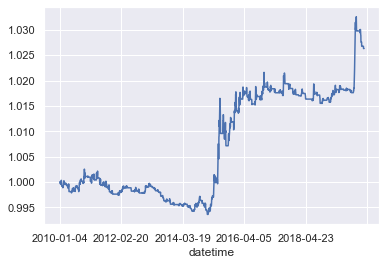

In [233]:
df_equity_copy['equity_curve'].plot()

In [229]:
sum(df_equity_copy.iloc[-86:-53]['daily_PL'])

1150.0

In [214]:
profits

[-451.5999999999767,
 -444.4000000000233,
 -147.59999999997672,
 -176.40000000002328,
 370.5999999999767,
 792.8000000000466,
 -207.0,
 128.59999999997672,
 -666.5999999999767,
 48.40000000002328,
 -462.4000000000233,
 -382.20000000018626,
 -520.8000000000466,
 676.0,
 -985.8000000002794,
 -748.5999999996275,
 -379.20000000006985,
 425.20000000018626,
 -682.4000000000233,
 -366.0,
 385.5999999998603,
 -128.60000000032596,
 -405.59999999962747,
 227.39999999990687,
 227.40000000002328,
 280.0,
 681.0,
 -441.79999999993015,
 -632.0,
 -338.20000000006985,
 577.4000000000233,
 -614.8000000000466,
 1769.6000000000931,
 -459.2000000003027,
 -407.4000000000233,
 -338.4000000000233,
 -113.59999999997672,
 318.19999999995343,
 1567.0,
 -325.4000000000233,
 -307.79999999993015,
 -500.5999999999767,
 -413.0,
 -115.0,
 -237.80000000004657,
 463.0,
 -605.8000000000466,
 217.20000000006985,
 1216.5999999999767,
 -258.80000000004657,
 -276.5999999999767,
 2389.8000000002794,
 -81.0,
 2638.79999999969

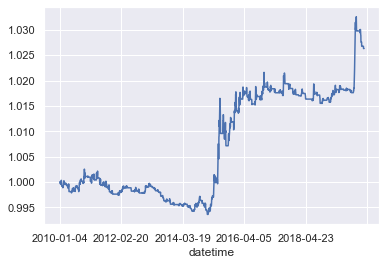

In [169]:
df_equity_copy['equity_curve'].plot()

In [162]:
df_equity.to_csv("df_equity_data_20200405.csv", index=False)

In [154]:
# Brad's version
len(profits)

108

In [165]:
profits[:10]

[-326.80000000004657,
 -521.7999999999302,
 461.19999999995343,
 -172.59999999997672,
 -269.80000000004657,
 -399.79999999993015,
 -684.4000000000233,
 201.19999999995343,
 867.4000000000233,
 -375.5999999999767]

In [158]:
# hansen's version
len(profits)

99

In [164]:
profits[:10]

[-326.80000000004657,
 -521.7999999999302,
 461.19999999995343,
 -172.59999999997672,
 -269.80000000004657,
 -399.79999999993015,
 -684.4000000000233,
 201.19999999995343,
 867.4000000000233,
 -375.5999999999767]

In [145]:
df_equity_copy.head(30)

,datetime,market_value,cash,commission,total,returns,equity_curve,drawdown,daily_PL
datetime,,,,,,,,,
2010-01-04,2010-01-04,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,NaN
2010-01-05,2010-01-05,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-06,2010-01-06,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-07,2010-01-07,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-08,2010-01-08,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-11,2010-01-11,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-12,2010-01-12,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-13,2010-01-13,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0
2010-01-14,2010-01-14,0.0,1000000.0,0,1000000.0,0.000000,1.000000,0.000000,0.0


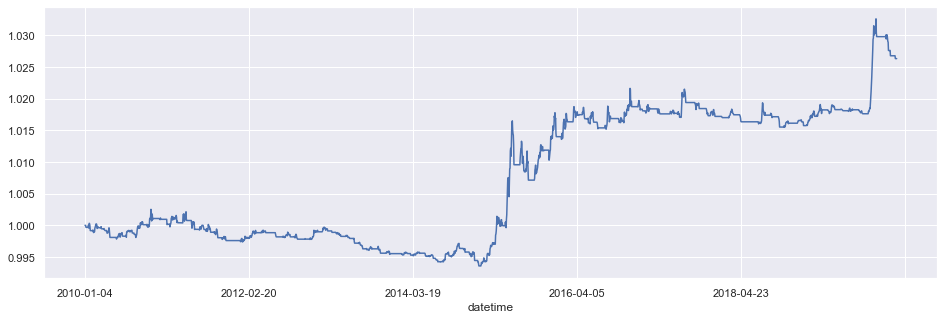

In [167]:
df_equity_copy['equity_curve'].plot(figsize = (16,5))

In [122]:
len(profits)

108

In [97]:
96013.4560+3991.544000000009

100005.00000000001

In [117]:
win_rate, mean_win_loss_ratio, bt_score, profits = performance(df_equity_copy)
# 问题：有commissions的反而分数高

Position is empty:  2010-01-04
Position is empty:  2010-01-05
Position is empty:  2010-01-06
Position is empty:  2010-01-07
Position is empty:  2010-01-08
Position is empty:  2010-01-11
Position is empty:  2010-01-12
Position is empty:  2010-01-13
Position is empty:  2010-01-14
Position is empty:  2010-01-15
Position is empty:  2010-01-18
Position is empty:  2010-01-19
Position is empty:  2010-01-20
Position is empty:  2010-01-22
Position is empty:  2010-01-25
Position is empty:  2010-01-26
Position is empty:  2010-01-27
Position is empty:  2010-01-28
Position is empty:  2010-01-29
-------------------
Opened the position:  2010-02-01
Holding the position:  2010-02-02
Holding the position:  2010-02-03
Holding the position:  2010-02-04
Holding the position:  2010-02-05
Holding the position:  2010-02-08
Holding the position:  2010-02-09
Closed the posotion:  2010-02-10
This trade's pnl: -3991.544000000009
-------------------
Position is empty:  2010-02-10
Position is empty:  2010-02-11
Po

Holding the position:  2011-01-17
Closed the posotion:  2011-01-18
This trade's pnl: -4811.071400000001
-------------------
Position is empty:  2011-01-18
Position is empty:  2011-01-19
Position is empty:  2011-01-20
Position is empty:  2011-01-21
Position is empty:  2011-01-24
Position is empty:  2011-01-25
Position is empty:  2011-01-26
-------------------
Opened the position:  2011-01-27
Closed the posotion:  2011-01-28
This trade's pnl: -4005.5917000000045
-------------------
Position is empty:  2011-01-28
Position is empty:  2011-01-31
Position is empty:  2011-02-01
Position is empty:  2011-02-09
Position is empty:  2011-02-10
Position is empty:  2011-02-11
Position is empty:  2011-02-14
-------------------
Opened the position:  2011-02-15
Holding the position:  2011-02-16
Holding the position:  2011-02-17
Holding the position:  2011-02-18
Holding the position:  2011-02-21
Holding the position:  2011-02-22
Holding the position:  2011-02-23
Holding the position:  2011-02-24
Holding

Holding the position:  2012-04-25
Holding the position:  2012-04-27
Holding the position:  2012-05-02
Holding the position:  2012-05-03
Holding the position:  2012-05-04
Holding the position:  2012-05-07
Holding the position:  2012-05-08
Holding the position:  2012-05-09
Holding the position:  2012-05-10
Closed the posotion:  2012-05-11
This trade's pnl: 3028.2550000000338
-------------------
Position is empty:  2012-05-11
Position is empty:  2012-05-14
Position is empty:  2012-05-15
Position is empty:  2012-05-16
Position is empty:  2012-05-17
Position is empty:  2012-05-18
Position is empty:  2012-05-21
Position is empty:  2012-05-22
Position is empty:  2012-05-23
Position is empty:  2012-05-24
Position is empty:  2012-05-25
Position is empty:  2012-05-28
Position is empty:  2012-05-29
-------------------
Opened the position:  2012-05-30
Holding the position:  2012-05-31
Holding the position:  2012-06-01
Holding the position:  2012-06-04
Holding the position:  2012-06-05
Holding the 

Holding the position:  2013-08-07
Holding the position:  2013-08-08
Holding the position:  2013-08-09
Holding the position:  2013-08-12
Holding the position:  2013-08-13
Holding the position:  2013-08-14
Holding the position:  2013-08-15
Holding the position:  2013-08-16
Holding the position:  2013-08-19
Holding the position:  2013-08-20
Holding the position:  2013-08-21
Closed the posotion:  2013-08-22
This trade's pnl: 17573.819000000003
-------------------
Position is empty:  2013-08-22
Position is empty:  2013-08-23
Position is empty:  2013-08-26
Position is empty:  2013-08-27
Position is empty:  2013-08-28
Position is empty:  2013-08-29
Position is empty:  2013-08-30
Position is empty:  2013-09-02
Position is empty:  2013-09-03
Position is empty:  2013-09-04
Position is empty:  2013-09-05
Position is empty:  2013-09-06
Position is empty:  2013-09-09
-------------------
Opened the position:  2013-09-10
Holding the position:  2013-09-11
Holding the position:  2013-09-12
Holding the 

Closed the posotion:  2014-09-16
This trade's pnl: -2549.6020000000135
-------------------
Position is empty:  2014-09-16
Position is empty:  2014-09-17
Position is empty:  2014-09-18
Position is empty:  2014-09-19
Position is empty:  2014-09-22
Position is empty:  2014-09-23
Position is empty:  2014-09-24
Position is empty:  2014-09-25
Position is empty:  2014-09-26
Position is empty:  2014-09-29
Position is empty:  2014-09-30
Position is empty:  2014-10-08
-------------------
Opened the position:  2014-10-09
Holding the position:  2014-10-10
Holding the position:  2014-10-13
Holding the position:  2014-10-14
Holding the position:  2014-10-15
Holding the position:  2014-10-16
Holding the position:  2014-10-17
Holding the position:  2014-10-20
Closed the posotion:  2014-10-21
This trade's pnl: -2707.124299999996
-------------------
Position is empty:  2014-10-21
Position is empty:  2014-10-22
Position is empty:  2014-10-23
Position is empty:  2014-10-24
Position is empty:  2014-10-27
P

Holding the position:  2015-11-10
Holding the position:  2015-11-11
Holding the position:  2015-11-12
Holding the position:  2015-11-13
Holding the position:  2015-11-16
Closed the posotion:  2015-11-17
This trade's pnl: -3421.5204999999987
-------------------
Position is empty:  2015-11-17
Position is empty:  2015-11-18
Position is empty:  2015-11-19
Position is empty:  2015-11-20
-------------------
Opened the position:  2015-11-23
Closed the posotion:  2015-11-24
This trade's pnl: -1953.616599999994
-------------------
Position is empty:  2015-11-24
Position is empty:  2015-11-25
Position is empty:  2015-11-26
Position is empty:  2015-11-27
Position is empty:  2015-11-30
Position is empty:  2015-12-01
Position is empty:  2015-12-02
Position is empty:  2015-12-03
-------------------
Opened the position:  2015-12-04
Holding the position:  2015-12-07
Closed the posotion:  2015-12-08
This trade's pnl: -4041.410000000018
-------------------
Position is empty:  2015-12-08
Position is empt

Holding the position:  2016-10-25
Holding the position:  2016-10-26
Holding the position:  2016-10-27
Holding the position:  2016-10-28
Holding the position:  2016-10-31
Holding the position:  2016-11-01
Holding the position:  2016-11-02
Closed the posotion:  2016-11-03
This trade's pnl: -5.0
-------------------
Position is empty:  2016-11-03
Position is empty:  2016-11-04
Position is empty:  2016-11-07
Position is empty:  2016-11-08
Position is empty:  2016-11-09
Position is empty:  2016-11-10
Position is empty:  2016-11-11
-------------------
Opened the position:  2016-11-14
Holding the position:  2016-11-15
Holding the position:  2016-11-16
Holding the position:  2016-11-17
Holding the position:  2016-11-18
Holding the position:  2016-11-21
Holding the position:  2016-11-22
Holding the position:  2016-11-23
Holding the position:  2016-11-24
Holding the position:  2016-11-25
Holding the position:  2016-11-28
Holding the position:  2016-11-29
Holding the position:  2016-11-30
Holding 

Position is empty:  2017-09-25
Position is empty:  2017-09-26
Position is empty:  2017-09-27
Position is empty:  2017-09-28
Position is empty:  2017-09-29
Position is empty:  2017-10-09
Position is empty:  2017-10-10
Position is empty:  2017-10-11
Position is empty:  2017-10-12
Position is empty:  2017-10-13
Position is empty:  2017-10-16
Position is empty:  2017-10-17
Position is empty:  2017-10-18
Position is empty:  2017-10-19
-------------------
Opened the position:  2017-10-20
Holding the position:  2017-10-23
Holding the position:  2017-10-24
Holding the position:  2017-10-25
Holding the position:  2017-10-26
Holding the position:  2017-10-27
Holding the position:  2017-10-30
Holding the position:  2017-10-31
Holding the position:  2017-11-01
Holding the position:  2017-11-02
Holding the position:  2017-11-03
Holding the position:  2017-11-06
Holding the position:  2017-11-07
Closed the posotion:  2017-11-08
This trade's pnl: -713.9236999999557
-------------------
Position is emp

Position is empty:  2018-10-17
Position is empty:  2018-10-18
Position is empty:  2018-10-19
Position is empty:  2018-10-22
Position is empty:  2018-10-23
Position is empty:  2018-10-24
Position is empty:  2018-10-25
-------------------
Opened the position:  2018-10-26
Holding the position:  2018-10-29
Holding the position:  2018-10-30
Holding the position:  2018-10-31
Holding the position:  2018-11-01
Holding the position:  2018-11-02
Holding the position:  2018-11-05
Holding the position:  2018-11-06
Holding the position:  2018-11-07
Holding the position:  2018-11-08
Holding the position:  2018-11-09
Holding the position:  2018-11-12
Holding the position:  2018-11-13
Holding the position:  2018-11-14
Holding the position:  2018-11-15
Holding the position:  2018-11-16
Holding the position:  2018-11-19
Holding the position:  2018-11-20
Holding the position:  2018-11-21
Holding the position:  2018-11-22
Holding the position:  2018-11-23
Holding the position:  2018-11-26
Holding the posi

Holding the position:  2019-12-03
Holding the position:  2019-12-04
Holding the position:  2019-12-05
Holding the position:  2019-12-06
Holding the position:  2019-12-09
Holding the position:  2019-12-10
Holding the position:  2019-12-11
Holding the position:  2019-12-12
Holding the position:  2019-12-13
Holding the position:  2019-12-16
Holding the position:  2019-12-17
Holding the position:  2019-12-18
Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-25
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Holding the position:  2020-01-10
Closed the posotion:  2020-01-13
This trade's pn

In [86]:
list(filter(lambda x: x >0, profits))

[3197.956999999995,
 906.2310999999754,
 941.0362000000023,
 4610.26739999999,
 708.987999999983,
 3908.290399999998,
 4238.08269999997,
 143.7612999999983,
 528.488199999978,
 323.8384000000078,
 2026.2409000000043,
 2002.4245999999985,
 325.7387999999919,
 334.4259999999922,
 1934.2936999999947,
 2302.2507999999943,
 791.0649999999878,
 2609.870200000005,
 178.29520000000775,
 1449.350499999986,
 175.41190000002098,
 10029.34080000002,
 2235.0929999999935,
 3046.229500000045,
 1195.1300000000047,
 250.21820000000298,
 957.8211999999912,
 1931.4944999999861,
 9947.747199999954,
 9966.122599999988,
 3095.25089999997,
 3439.838499999998,
 1742.026400000017,
 1593.4804000000004,
 138.7436000000016,
 571.7746000000043,
 2391.4260000000068,
 3488.3678000000073,
 677.0,
 655.9899999999616,
 1186.4214999999967,
 368.6699999999837,
 1042.420000000042,
 1145.026899999997,
 409.34189999999944,
 1167.9599999999919,
 1385.8000000000175]

In [85]:
len(profits)

108

In [90]:
df_equity_copy.head(30)

,datetime,market_value,cash,commission,total,returns,equity_curve,drawdown,daily_PL
datetime,,,,,,,,,
2010-01-04,2010-01-04,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,NaN
2010-01-05,2010-01-05,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-06,2010-01-06,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-07,2010-01-07,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-08,2010-01-08,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-11,2010-01-11,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-12,2010-01-12,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-13,2010-01-13,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000
2010-01-14,2010-01-14,0.0000,100000.0000,0,100000.0000,0.000000,1.000000,0.000000,0.0000


In [ ]:
103200.5745	

In [16]:
# df_equity.to_csv("df_equity_data.csv", index = False)

# Loop backtest for each ticker and find the best backtest performances

In [17]:
df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
       'equity_curve', 'drawdown']

In [18]:
df_equity_copy = df_equity.copy()
data = df_equity_copy



# performance(data)
# print(data.head())